In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import optimize 

In [21]:
# Load df with the stock prices

data = pd.read_csv('data.csv')
data

,Date,AAPL,MSFT,AMZN,GOOGL
0,2021-01-04,128.087067,214.479126,159.331497,86.306503
1,2021-01-05,129.670731,214.686005,160.925507,87.002502
2,2021-01-06,125.305794,209.119339,156.919006,86.143997
3,2021-01-07,129.581635,215.070236,158.108002,88.717003
4,2021-01-08,130.700089,216.380630,159.134995,89.891502
...,...,...,...,...,...
246,2021-12-23,175.553543,332.517456,171.068497,146.916504
247,2021-12-27,179.586868,340.227112,169.669495,147.906494
248,2021-12-28,178.551132,339.034882,170.660995,146.686996
249,2021-12-29,178.640778,339.730377,169.201004,146.654999


In [22]:
# Create a df with daily log returns

ret = np.log(data[['AAPL', 'MSFT', 'AMZN', 'GOOGL']]/data[['AAPL', 'MSFT', 'AMZN', 'GOOGL']].shift(1))
ret = ret.fillna(0)
ret.insert(loc = 0, column = 'date', value = data.Date)
ret

,date,AAPL,MSFT,AMZN,GOOGL
0,2021-01-04,0.000000,0.000000,0.000000,0.000000
1,2021-01-05,0.012288,0.000964,0.009955,0.008032
2,2021-01-06,-0.034241,-0.026271,-0.025212,-0.009917
3,2021-01-07,0.033554,0.028060,0.007549,0.029431
4,2021-01-08,0.008594,0.006074,0.006475,0.013152
...,...,...,...,...,...
246,2021-12-23,0.003637,0.004462,0.000184,0.003419
247,2021-12-27,0.022715,0.022921,-0.008212,0.006716
248,2021-12-28,-0.005784,-0.003510,0.005827,-0.008279
249,2021-12-29,0.000502,0.002049,-0.008592,-0.000218


In [25]:
type(ret.mean())

C:\Users\DavidLiu\AppData\Local\Temp\ipykernel_25344\1541893877.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  type(ret.mean())


pandas.core.series.Series

In [26]:
# Create portfolio with random weights, and compute stats:

np.random.seed(22) # set seed for reproducibility

rf_ret = 0.04 # risk-free return
n_ptf = 1000
weights = np.zeros((n_ptf, 4)) #1000 rows, 4 columns Array
ptf_rets = np.zeros(n_ptf) # ptf returns
ptf_volas = np.zeros(n_ptf) # ptf volatilities
ptf_SRs = np.zeros(n_ptf) # ptf Sharpe Ratios

for idx in range(n_ptf):
    
    # Weights for each portfolio:
    w = np.array(np.random.random(4))
    w = w / np.sum(w) # to normalize weights
    
    # Fill weights matrix:
    weights[idx, :] = w # all columns for each row
    
    # Expected return for each portfolio:
    ptf_rets[idx] = np.sum((ret.mean() * w * 252)) # 252 to annualize: 252 t-days in a year
    
    # Volatility for each portfolio
    ptf_volas[idx] = np.sqrt(np.dot(w.T, np.dot(ret.cov() * 252, w))) # 252 to annualize: 252 t-days in a year
    
    # Sharpe Ratio for each portfolio:
    ptf_SRs[idx] = (ptf_rets[idx] - rf_ret) / ptf_volas[idx]

C:\Users\DavidLiu\AppData\Local\Temp\ipykernel_25344\2999054259.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ptf_rets[idx] = np.sum((ret.mean() * w * 252)) # 252 to annualize: 252 t-days in a year


In [28]:
# Portofolio with highest Sharpe Ratio:

print("The portofolio with the highest SR is pft #", ptf_SRs.argmax())
print("its expected return is:", ptf_rets[ptf_SRs.argmax()])
print("its volatility is:", ptf_volas[ptf_SRs.argmax()])
print("its SR is:", ptf_SRs.max())
print("and its weights for AAPL, MSFT, AMZN, GOOGL are, respectively:", 100 * weights[ptf_SRs.argmax(), :], "%")

The portofolio with the highest SR is pft # 853
its expected return is: 0.4951330805362337
its volatility is: 0.2156815010203433
its SR is: 2.110209166679089
and its weights for AAPL, MSFT, AMZN, GOOGL are, respectively: [ 0.14256803 32.01979639  2.05217619 65.78545938] %


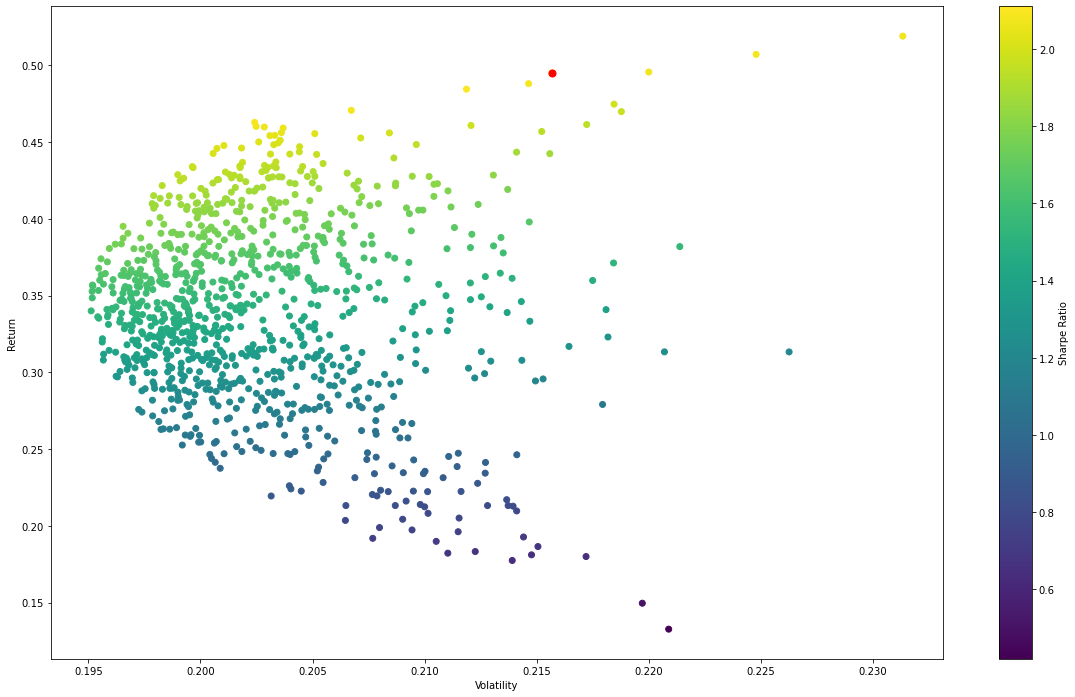

In [29]:
# Investment set plot:

plt.figure(figsize = (20,12))
plt.scatter(ptf_volas, ptf_rets, c = ptf_SRs)
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(ptf_volas[ptf_SRs.argmax()], ptf_rets[ptf_SRs.argmax()], c = 'red', s = 50) # to highlight the ptf with highest SR
plt.show()

In [32]:
# Find optimal portfolio:

# return 0 if weights sum to 1
def weights_const(w):
    return np.sum(w) - 1

# Function to be minimized: negative of sharpe ratio
def inv_SR(w):
    w = np.array(w)
    ret_w = np.sum(ret.mean() * w) * 252
    vola_w = np.sqrt(np.dot(w.T, np.dot(ret.cov() * 252, w)))
    sr_w = (ret_w - rf_ret)/ vola_w
    return -1 * sr_w

const = ({'type': 'eq', 'fun': weights_const}) # optimization constraints
bounds = ((0, 1), (0, 1), (0, 1), (0, 1)) # weights bounds
x0 = [0.25, 0.25, 0.25, 0.25] # starting point for optimization

optim_ptf = optimize.minimize(inv_SR, x0, method = 'SLSQP', bounds = bounds, constraints = const)
print(optim_ptf)

C:\Users\DavidLiu\AppData\Local\Temp\ipykernel_25344\386129568.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ret_w = np.sum(ret.mean() * w) * 252


     fun: -2.1595840282253502
     jac: array([ 0.13991964, -0.19141194,  1.28437683, -0.19132364])
 message: 'Optimization terminated successfully'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.00000000e+00, 5.02636581e-01, 5.13145170e-16, 4.97363419e-01])


In [33]:
# Get return, vola and SR from optimal ptf: optim_ptf.x = optimal weights
# Compare with the "optimal" ptf stats obtained before

opt_ret = np.sum(ret.mean() * optim_ptf.x) * 252
opt_vola = np.sqrt(np.dot(optim_ptf.x.T, np.dot(ret.cov() * 252, optim_ptf.x)))
opt_sr = opt_ret / opt_vola

print("Optimal weights:", optim_ptf.x, "%")
print("Optimal return:", opt_ret)
print("Optimal volatility:", opt_vola)
print("Optimal Sharpe ratio:", opt_sr)

Optimal weights: [0.00000000e+00 5.02636581e-01 5.13145170e-16 4.97363419e-01] %
Optimal return: 0.4913991010212007
Optimal volatility: 0.2090213185138901
Optimal Sharpe ratio: 2.3509520680233664


C:\Users\DavidLiu\AppData\Local\Temp\ipykernel_25344\2725320078.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  opt_ret = np.sum(ret.mean() * optim_ptf.x) * 252


In [ ]:
# Find efficient frontier: takes a little while

# Functions to be used for optimization:
def get_vola(w):
    w = np.array(w)
    vola_w = np.sqrt(np.dot(w.T, np.dot(ret.cov() * 252, w)))
    return vola_w
def get_ret(w):
    w = np.array(w)
    ret_w = np.sum(ret.mean() * w) * 252
    return ret_w

# Estimated min and max ret by looking at the chart above:
min_ret = 0.1
max_ret = 0.55 

# Define efficient frontier: we will minimize volatility for every level of return (you could also do the opposite)
eff_front_yaxis = np.linspace(min_ret, max_ret, 300)
eff_front_xaxis = []

# Loop across all possible return between min and max ret:
for rets in eff_front_yaxis:
    const = ({'type': 'eq', 'fun': weights_const},
            {'type': 'eq', 'fun': lambda w: get_ret(w) - rets})
    
    opt_vola = optimize.minimize(get_vola, x0, method = 'SLSQP', bounds = bounds, constraints = const)
    eff_front_xaxis.append(opt_vola['fun'])

In [ ]:
# Investment set + efficient frontier plot:

plt.figure(figsize = (20, 12))
plt.scatter(ptf_volas, ptf_rets, c = ptf_SRs) # investment set
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(eff_front_xaxis, eff_front_yaxis, 'k--', linewidth = 3) # efficient frontier
plt.scatter(ptf_volas[ptf_SRs.argmax()], ptf_rets[ptf_SRs.argmax()], c = 'red', s = 50) # to highlight the ptf with highest SR
plt.show()